In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [3]:
geo = geo = pd.read_csv('../datasets/hackathon_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [4]:
geo_train, geo_test = train_test_split(geo, test_size=0.3)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [5]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [6]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [7]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Дискретная структра + смешанные параметры

In [8]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI_mixed', geo_types)

  0%|          | 14/1000000 [00:04<79:29:01,  3.49it/s]


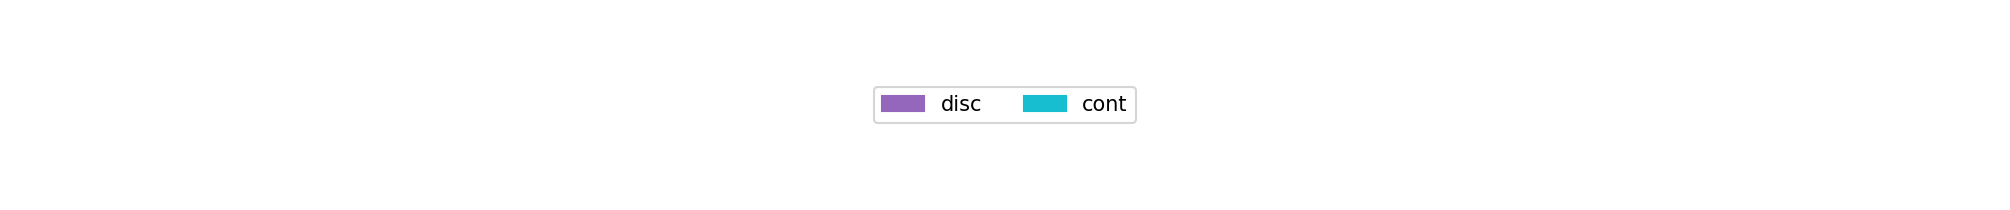

In [9]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [10]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [11]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [12]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

3
3
6
6
6
7
7
7
11
11
12
12
12
13
13
17
18
18
21
21
21
22
22
22
22
23
26
26
27
27
27
29
29
32
32
34
35
36
36
39
39
39
42
42
42
44
51
52
52
54
54
54
55
56
56
56
57
57
62
63
64
64
70
71
74
74
75
75
78
78
79
80
80
81
82
82
82
82
88
96
97
98
98
98
99
101
101
102
103
103
103
105
105
111
118
118
120
120
121
123
126
129


In [13]:
acc

{'Tectonic regime': 0.52,
 'Period': 0.25,
 'Lithology': 0.59,
 'Structural setting': 0.58,
 'Hydrocarbon type': 0.71}

In [14]:
rmse

{'Gross': 441.17,
 'Netpay': 50.07,
 'Porosity': 6.18,
 'Permeability': 834.07,
 'Depth': 884.19}

# Смешанная структура + смешанные параметры

In [15]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI_mixed', geo_types)

  0%|          | 8/1000000 [00:11<395:16:24,  1.42s/it]


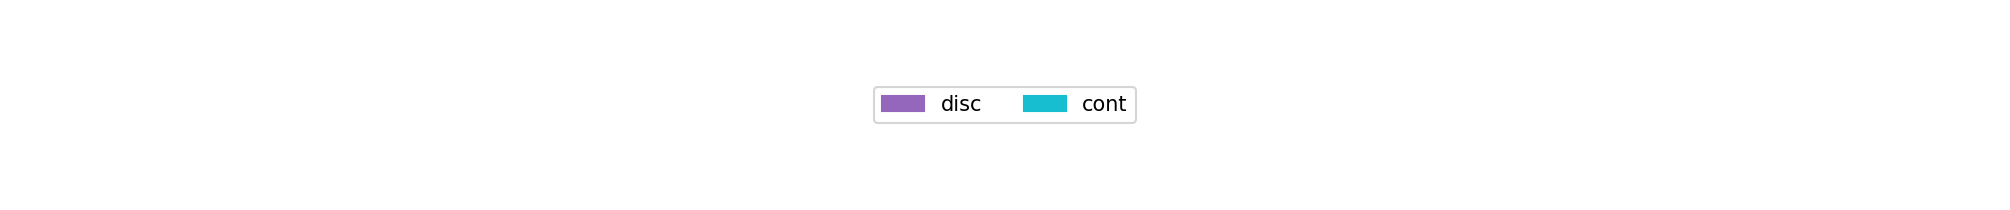

In [16]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [17]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [18]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [19]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

22
51
51
51
57
71
71
71
82
120
120
120


In [20]:
acc

{'Tectonic regime': 0.52,
 'Period': 0.25,
 'Lithology': 0.59,
 'Structural setting': 0.58,
 'Hydrocarbon type': 0.71}

In [21]:
rmse

{'Gross': 484.84,
 'Netpay': 99.87,
 'Porosity': 7.55,
 'Permeability': 1004.35,
 'Depth': 1082.72}

# Дискретная стурктура + дискретные параметры

In [22]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [28]:
bn_geo = structure_learning(geo_only_discrete, 'HC', 'MI_mixed', geo_new_types)

  0%|          | 14/1000000 [00:04<96:05:25,  2.89it/s] 


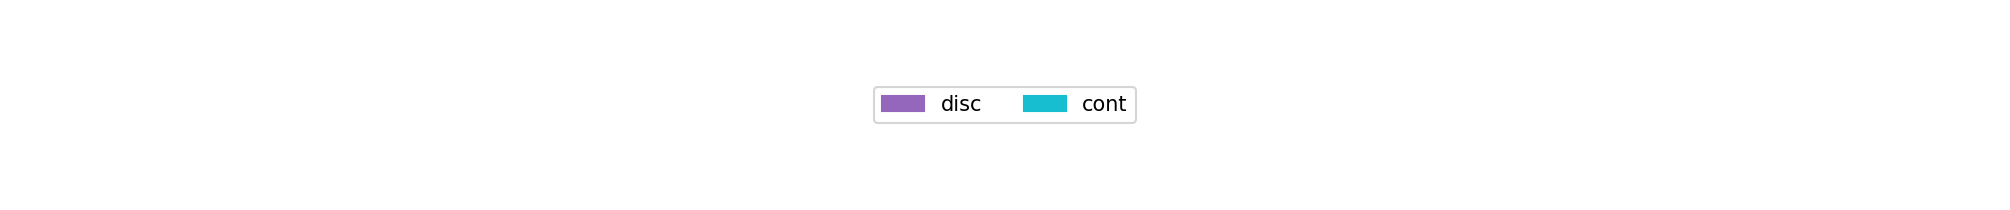

In [29]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [30]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [31]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [33]:
test_discrete = copy(geo_test)

In [34]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [37]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Gross,Netpay,Porosity,Permeability,Depth
0,GRAVITY,JURASSIC,LIMESTONE,SALT,OIL,1,2,4,3,2
1,EXTENSION,NEOGENE,SANDSTONE,RIFT,OIL,4,1,4,4,1
2,COMPRESSION,CRETACEOUS,SANDSTONE,FORELAND,OIL,0,0,3,1,1
3,COMPRESSION,PALEOGENE-NEOGENE,LIMESTONE,FORELAND,OIL,4,4,3,2,0
4,GRAVITY,CRETACEOUS,SANDSTONE,SALT,OIL,2,1,4,4,1
...,...,...,...,...,...,...,...,...,...,...
128,COMPRESSION,CRETACEOUS,SANDSTONE,FORELAND,GAS,1,1,3,3,4
129,INVERSION,PALEOGENE,SANDSTONE,INVERSION,GAS,2,4,4,4,0
130,INVERSION,PALEOGENE,SANDSTONE,RIFT,OIL,3,0,4,4,0
131,COMPRESSION,DEVONIAN,LIMESTONE,FORELAND,OIL,3,2,0,2,0


In [38]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

6
6
6
7
7
7
12
12
12
21
21
21
22
22
22
22
27
27
27
39
39
39
42
42
42
51
56
56
56
57
57
71
82
82
82
82
98
98
98
103
103
103
120
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklear

In [52]:
acc

{'Tectonic regime': 0.52,
 'Period': 0.24,
 'Lithology': 0.59,
 'Structural setting': 0.58,
 'Hydrocarbon type': 0.71,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [49]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [50]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [54]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)

15.259518956932832